<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RecSys/blob/main/Paul%20Himyak/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import uuid
import re
import numpy as np
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split 

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import concatenate, Embedding, Conv1D, Input, Dense, Dropout, BatchNormalization, Flatten , SpatialDropout1D, Reshape, RepeatVector, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.losses as keras_losses
import tensorflow.keras.metrics as keras_metrics
from tensorflow.keras import utils


import gdown

In [4]:
dataset_url = "https://drive.google.com/uc?export=download&id=1ErXvN290PPthLGsb0ALpa_0aUDnvC0jg"
#dataset_url = "https://docs.google.com/spreadsheets/d/1ErXvN290PPthLGsb0ALpa_0aUDnvC0jg/edit?usp=share_link&ouid=113369956649761615778&rtpof=true&sd=true"
dataset_filename = "profpatolog_modified.xlsx"
#!wget -qc dataset_url -O dataset_filename
gdown.download(dataset_url, output=dataset_filename, quiet=True )


'profpatolog_modified.xlsx'

In [5]:
df = pd.read_excel("profpatolog_modified.xlsx")


In [6]:
#Удаляем случайные вбросы
df.drop([843, 851, 1022, 1024], inplace = True)

#Убираем пустые колонки
empty_columns = df.columns[df.isna().all()]
df.drop(empty_columns, inplace = True, axis = 1)

In [7]:
del df['Unnamed: 0']

In [8]:
FIELD_CLIENT_AGE = "КлиентВозраст"
FIELD_CLIENT_BIRTH_DAY = "КлиентДатаРождения"
FIELD_CLIENT_GENDER = "КлиентПол"
FIELD_CLIENT_GENDER_M = 0
FIELD_CLIENT_GENDER_F = 1
FIELD_CONCLUSION = "ЗаключениеМК"
FIELD_CONCLUSION_FIT = 0
FIELD_CONCLUSION_PART_FIT = 1
FIELD_CONCLUSION_NOT_FIT = 2

FIELD_DISPANSARY_GROUP = "ДиспансернаяГруппа"
FIELD_DISPANSARY_GROUP_I = 0
FIELD_DISPANSARY_GROUP_II = 1
FIELD_DISPANSARY_GROUP_III = 2
FIELD_DISPANSARY_GROUP_OTHER = 3

FIELD_HARMFUL_FACTORS = "ВредныеФакторы"


FIELD_NEW_AGE_CATEGORY = "ВозрастКатегория"

FIELD_CLIENT_PROFESSION = "Профессия"

In [9]:
from datetime import datetime
class MyUtils:
  @staticmethod  
  # Определяем функцию для расчета возраста на основе даты
  def resolve_birthdate_to_age(date):
    current_year = pd.Timestamp.now().year
    age = current_year - date.year
    return age
  def resolve_genger(x):
    if x == 'Мужской':
        return FIELD_CLIENT_GENDER_M
    elif x == 'Женский':
        return FIELD_CLIENT_GENDER_F
    else:
        return None
  def resolve_conclusion(arg):
    try:
      if "Годен" == arg:
        return FIELD_CONCLUSION_FIT
      elif "Негоден" in arg:
        return FIELD_CONCLUSION_NOT_FIT
      elif "Годен" in arg:
        return FIELD_CONCLUSION_PART_FIT
      else:
        return FIELD_CONCLUSION_NOT_FIT
    except (TypeError):
        return None
  def resolve_dispansary_group(arg):
    try:
      if arg == "I":
        return FIELD_DISPANSARY_GROUP_I
      elif arg == "II":
        return FIELD_DISPANSARY_GROUP_II
      elif "III" in arg :
        return FIELD_DISPANSARY_GROUP_III
      else:
        return FIELD_DISPANSARY_GROUP_OTHER
    except (TypeError):
        return None
  def resolve_age_to_category(arg):
    outClass =int((arg-13)/5)
    outClass = max(0, min(10,outClass))
    return outClass

In [10]:
df[FIELD_CLIENT_AGE] = df[FIELD_CLIENT_BIRTH_DAY].apply(MyUtils.resolve_birthdate_to_age)

In [11]:
df[FIELD_NEW_AGE_CATEGORY] = df[FIELD_CLIENT_AGE].apply(MyUtils.resolve_age_to_category)

In [12]:
df[FIELD_CLIENT_GENDER] = df[FIELD_CLIENT_GENDER].apply(lambda x: MyUtils.resolve_genger(x) if pd.notnull(x) else x)

In [13]:
del df[FIELD_CLIENT_BIRTH_DAY]

In [14]:
del  df[FIELD_CLIENT_AGE]

In [15]:
df[FIELD_DISPANSARY_GROUP] = df[FIELD_DISPANSARY_GROUP].apply(MyUtils.resolve_dispansary_group)

In [16]:
df[FIELD_CONCLUSION] = df[FIELD_CONCLUSION].apply(lambda x: MyUtils.resolve_conclusion(x))

In [17]:
mkb_columns = df.filter(regex="(?i)МКБ10").columns


In [18]:
df[mkb_columns] = df[mkb_columns].fillna(value='Z00.0')

In [19]:
# объединяем значения из нескольких столбцов в один массив, удаляем дубликаты
#df['mkb'] = df.apply(lambda row: list(set([row[mkb_col_name] for mkb_col_name in mkb_columns if not pd.isna(row[mkb_col_name]) ])), axis=1)
df['mkb'] = df.apply(lambda row: list(set([row[mkb_col_name] for mkb_col_name in mkb_columns])), axis=1)


In [20]:
df = df.loc[:, ~df.columns.str.contains('мкб10', case=False)]


In [21]:
df[FIELD_HARMFUL_FACTORS] = df[FIELD_HARMFUL_FACTORS].str.split(",")

<ipython-input-21-5df6e72f6511>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[FIELD_HARMFUL_FACTORS] = df[FIELD_HARMFUL_FACTORS].str.split(",")


In [22]:
df.dropna(inplace = True)

<ipython-input-22-d1ada024d2eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


In [23]:
df_ohe = pd.get_dummies(df[[FIELD_CLIENT_GENDER, FIELD_DISPANSARY_GROUP, FIELD_NEW_AGE_CATEGORY]],  columns = [FIELD_CLIENT_GENDER, FIELD_DISPANSARY_GROUP, FIELD_NEW_AGE_CATEGORY] )

In [24]:
xTrain0 = df_ohe.values

In [25]:
xTrain0.shape

(1562, 16)

In [26]:
yTrain =  pd.get_dummies(df[FIELD_CONCLUSION]).values

In [27]:
yTrain.shape

(1562, 3)

In [28]:
df

,КлиентПол,ЗаключениеМК,ДиспансернаяГруппа,ВредныеФакторы,Профессия,ВозрастКатегория,mkb
0,1,0.0,0.0,[11.4],Ведущий специалист по организации обуения,6,[Z00.0]
1,0,0.0,2.0,[4.2.5],Ведущий специалист,4,"[Z00.0, I11.9]"
2,0,1.0,1.0,[4.2.5],Главный менеджер,5,"[Z00.0, H52.1]"
3,0,0.0,0.0,[11.1],Главный специалист,4,[Z00.0]
4,0,1.0,1.0,[11.1],Старший специалист,5,"[Z00.0, H52.2]"
...,...,...,...,...,...,...,...
1960,0,0.0,1.0,"[4.4, 4.5, 6.1]",Инженер,4,"[Z00.0, H52.1]"
1961,0,0.0,0.0,"[4.4, 4.5, 6.1]",Инженер,3,[Z00.0]
1962,0,0.0,0.0,[4.4],Начальник лаборатории,4,[Z00.0]
1972,0,0.0,0.0,[3.1.8.2],"Инженер по бурению 1 категории, непосредственн...",4,[Z00.0]


In [29]:
df['mkb'].explode().unique()

array(['Z00.0', 'I11.9', 'H52.1', 'H52.2', 'H53.0', 'K29.3', 'I70',
       'H90.5', 'G90.9', 'H52.0', 'S68.2', 'N60.2', 'E11.9', 'K29.6',
       'M42.1', 'D25', 'I69.4', 'N83.2', 'H90.3', 'K44.9', 'N80.0',
       'G99.0', 'G12.1', 'K81.9', 'H11.0', 'G25.0', 'K26.9', 'H91.1',
       'K86.1', 'I67.2', 'H74.1', 'N28.1', 'I83.9', 'L40.0', 'H93.0',
       'D25.9', 'I25.8', 'K80.5', 'F06.6', 'K40.9', 'E11.8', 'E10.9',
       'T94.0', 'F10.7', 'D35.2', 'L20.8', 'K29.5', 'H50.9', 'K80.2',
       'I25.2', 'Q12.0', 'S51.9', 'F06.7', 'H25.0', 'I66.9', 'I67.9',
       'K29.8', 'T90.4', 'H40.1', 'H90.4', 'F41.0', 'R25.1', 'K29.7',
       'H47.2', 'J33.0', 'H66.1', 'K26.7', 'H02.4', 'I49.9', 'H01.0',
       'F98.5', 'I49.8', 'J45.8', 'H35.0', 'H17.1', 'J30.1', 'F07.0',
       'G58.9', 'J37.0', 'H25.1', 'I25.9', 'K82.9', 'J45.9', 'G90.8',
       'K29.4'], dtype=object)

In [84]:
tokenizer_mkb = Tokenizer()
tokenizer_mkb.fit_on_texts(np.array(df['mkb']))
mkb_vocab_size = len(tokenizer_mkb.word_index) + 1


In [86]:
xMkbIndexed = tokenizer_mkb.texts_to_sequences(df['mkb'])

In [87]:
mkb_max_len = max(len(sublist) for sublist in xMkbIndexed)
#mkb_max_len = max(xMkbIndexed, key=len)
print(mkb_max_len)

5


In [88]:
xMkbIndexedPadded = pad_sequences(xMkbIndexed, maxlen=mkb_max_len, padding='post')
xTrainMkb = xMkbIndexedPadded

In [89]:
xMkbIndexedPadded.shape

(1562, 5)

In [139]:
tokenizer_harmfull = Tokenizer()

In [140]:
tokenizer_harmfull.fit_on_texts(df[FIELD_HARMFUL_FACTORS])


In [144]:
harmfull_vocab_size = len(tokenizer_harmfull.word_index) + 1


In [141]:
xTrainHarmfulIndexes = tokenizer_harmfull.texts_to_sequences(df[FIELD_HARMFUL_FACTORS])

In [142]:
harm_max_len = max(len(sublist) for sublist in xTrainHarmfulIndexes)


In [143]:
xTrainHarmfulIndexesPadded = pad_sequences(xTrainHarmfulIndexes, maxlen=harm_max_len, padding='post')
xTrainHarmFull = xTrainHarmfulIndexesPadded

In [40]:
xTrainHarmFull.shape

(1562, 13)

In [41]:
maxWordsCount = 1000 
tokenizer_prof = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer_prof.fit_on_texts(df[FIELD_CLIENT_PROFESSION]) 


In [158]:
prof_vocab_size = len(tokenizer_prof.word_index) + 1


In [42]:
xTrainProfIndexed = tokenizer_prof.texts_to_sequences(df[FIELD_CLIENT_PROFESSION])

In [43]:
prof_max_len = max(len(sublist) for sublist in xTrainProfIndexed)


In [44]:
xTrainProfIndexedPadded = pad_sequences(xTrainProfIndexed, maxlen=prof_max_len, padding='post')
xTrainProf = xTrainProfIndexedPadded

In [45]:
xTrainProf.shape

(1562, 12)

In [145]:
x_train, x_test, x_train_mkb, x_test_mkb, x_train_harmfull, x_test_harmfull, x_train_prof, x_test_prof,  y_train, y_test = train_test_split(xTrain0,
                                                                                                              xTrainMkb,
                                                                                                              xTrainHarmFull,
                                                                                                              xTrainProf,                                                                                                              
                                                                                                              yTrain, 
                                                                                                              test_size=0.2,
                                                                                                              shuffle = False)

In [146]:
input0 = Input((x_train.shape[1],))
input_mkb = Input((x_train_mkb.shape[1],))
input_harmfull = Input((x_train_harmfull.shape[1],))
input_prof = Input((x_train_prof.shape[1],))

In [67]:
x_train_mkb[:3,:]

array([[1, 0, 0, 0, 0],
       [1, 2, 0, 0, 0],
       [1, 3, 0, 0, 0]], dtype=int32)

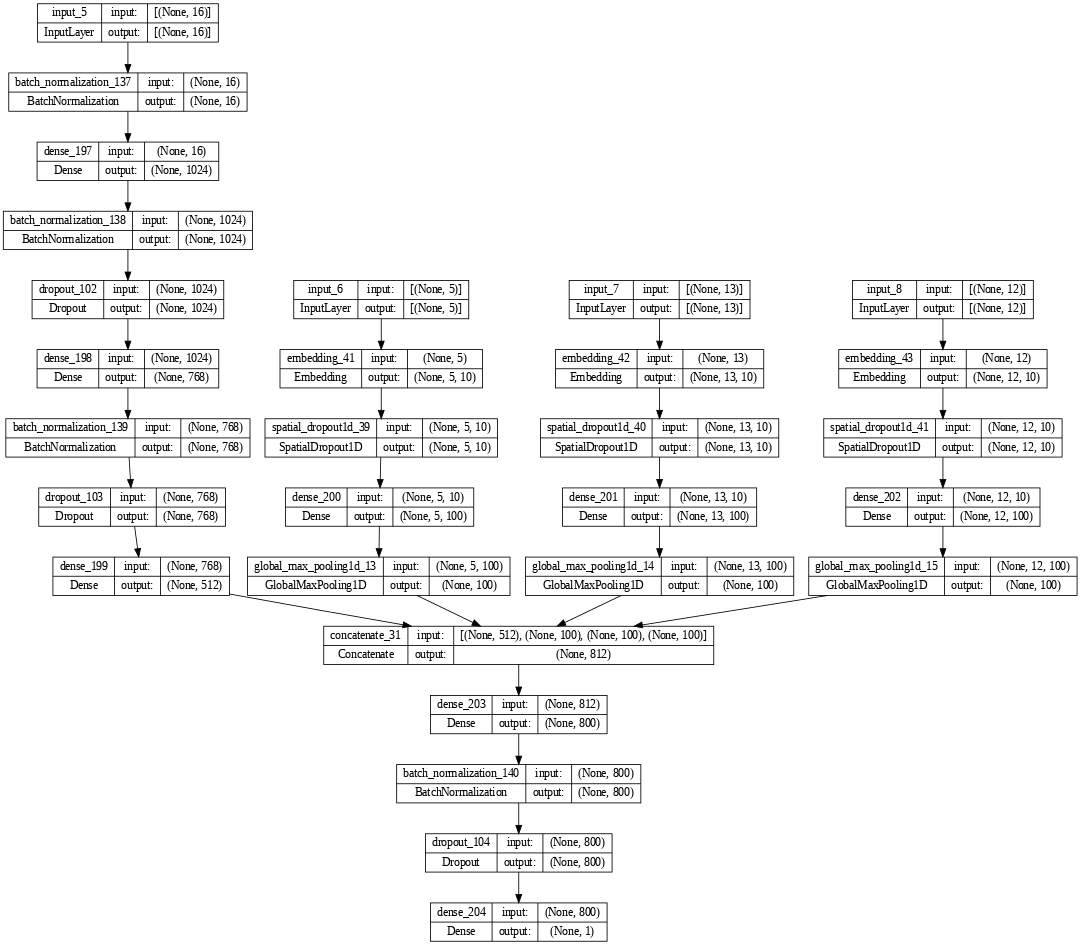

In [168]:
x0 = BatchNormalization()(input0)
x0 = Dense(1024, activation='relu') (x0)
x0 = BatchNormalization()(x0)
x0 = Dropout(0.3)(x0)
x0 = Dense(768, activation='sigmoid')(x0)
x0 = BatchNormalization()(x0)
x0 = Dropout(0.3)(x0)
x0 = Dense(512, activation='sigmoid')(x0)


x1 = Embedding(mkb_vocab_size, 10, input_length = mkb_max_len)(input_mkb)
x1 = SpatialDropout1D(0.2)(x1)
x1 = Dense(100, activation = 'sigmoid')(x1)
x1 = GlobalMaxPooling1D()(x1)

x2 = Embedding(harmfull_vocab_size, 10, input_length = harm_max_len)(input_harmfull)
x2 = SpatialDropout1D(0.2)(x2)
x2 = Dense(100, activation = 'sigmoid')(x2)
x2 = GlobalMaxPooling1D()(x2)

x3 = Embedding(prof_vocab_size, 10, input_length = prof_max_len)(input_prof)
x3 = SpatialDropout1D(0.2)(x3)
x3 = Dense(100, activation = 'sigmoid')(x3)
x3 = GlobalMaxPooling1D()(x3)

x = concatenate([x0, x1, x2, x3])


x = Dense(800, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='linear')(x)

model = Model((input0, input_mkb, input_harmfull, input_prof), x )
utils.plot_model(model, dpi=60, show_shapes = True)


In [169]:
model.compile(optimizer = Adam(learning_rate = 0.0003), loss = keras_losses.mse, metrics=[keras_metrics.mae])

In [162]:

# Визуальная оценка ошибки на обучающей и проверочной выборках

def compare_sharp_loss (history, x_size, y_size):
  
  plt.figure(figsize=(x_size,y_size))
  plt.plot(history.history['loss'], 
         label='Ошибка на обучающей выборке')
  
  plt.plot(history.history['val_loss'], 
         label='Ошибка проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Средняя ошибка')
  plt.legend()
  plt.show()

In [170]:
history = model.fit([x_train, x_train_mkb, x_train_harmfull, x_train_prof],
                    y_train,
                    batch_size=256,
                    epochs = 100,
                    validation_split = 0.15,
                    verbose = 1)

Epoch 1/100
5/5 [==============================] - 4s 191ms/step - loss: 2.0882 - mean_absolute_error: 1.1383 - val_loss: 0.3290 - val_mean_absolute_error: 0.5534
Epoch 2/100
5/5 [==============================] - 1s 128ms/step - loss: 1.4012 - mean_absolute_error: 0.9330 - val_loss: 0.3211 - val_mean_absolute_error: 0.5493
Epoch 3/100
5/5 [==============================] - 1s 182ms/step - loss: 1.2005 - mean_absolute_error: 0.8667 - val_loss: 0.3150 - val_mean_absolute_error: 0.5460
Epoch 4/100
5/5 [==============================] - 1s 180ms/step - loss: 0.9567 - mean_absolute_error: 0.7822 - val_loss: 0.3425 - val_mean_absolute_error: 0.5600
Epoch 5/100
5/5 [==============================] - 1s 159ms/step - loss: 0.9804 - mean_absolute_error: 0.7911 - val_loss: 0.4215 - val_mean_absolute_error: 0.5932
Epoch 6/100
5/5 [==============================] - 1s 166ms/step - loss: 0.9329 - mean_absolute_error: 0.7690 - val_loss: 0.4292 - val_mean_absolute_error: 0.5961
Epoch 7/100
5/5 [=====

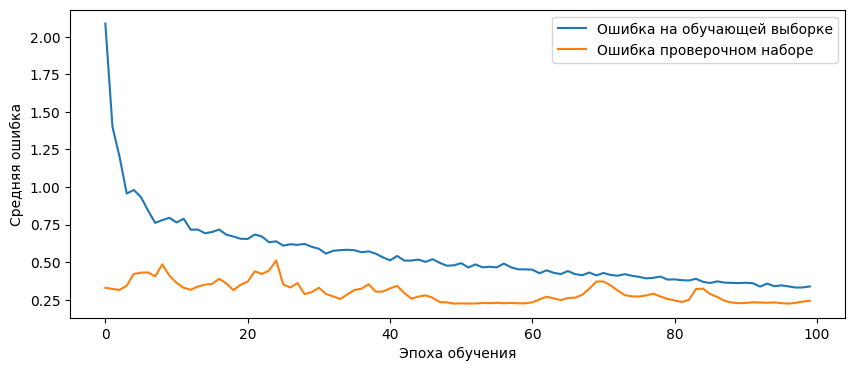

In [171]:
compare_sharp_loss(history, 10, 4)